# Find precipitation value for pulsed and upslope storms

In [1]:
import sys
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python')

import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt

import createFolder as cF
np.warnings.filterwarnings('ignore')



In [2]:
m = ['11', '12', '01', '02', '03']
station = 'Haukeliseter'

In [3]:
savefig = 0
if savefig == 1:
    figdir = '../../Figures/Weathermast_MEPS/%s/wind_precip' %(station)
    cF.createFolder('%s/' %figdir)
form = 'png'

In [4]:
f = dict()
obs_precip_diff      = dict()
obs_precip_diff_2deg = dict()
obs_west_idx         = dict()
obs_east_idx         = dict()
obs_wind_dir         = dict()
obs_wind_speed       = dict()
    
meps_precip_diff     = dict()
meps_precip_diff_2deg= dict()
meps_west_idx        = dict()
meps_east_idx        = dict()
meps_wind_dir        = dict()
meps_wind_speed      = dict()
    
ret_precip_diff      = dict()


for month in m:
    if month == '11':
#        t = np.arange(8,31)
        t = [9, 12, 13, 14, 15, 16, 17, 23, 24, 26,29,30]
    if month == '12': #or  or 
 #       t = np.arange(1,32)
        t = [7, 9, 10, 11, 12, 13, 15, 21, 22, 23, 24, 25, 26, 29, 30, 31]
    if month == '01':
        t = [2, 3, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 28, 29]
    if month == '02':
  #      t = np.arange(1,29)
        t = [2, 3, 4, 6]
    if month == '03':
        t = [9, 14, 16, 17, 19, 21, 24, 30, 31]
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    
    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
            
        Date = int(year+month+day)
        nc_dir = '../../Data/Weathermast_MEPS_Retrieval/'+station+'/weathermast_meps_retrieval_%s.nc' %(Date)

        f[Date] = netCDF4.Dataset(nc_dir, 'r')

        obs_wind_dir[Date]         = f[Date].variables['obs_wind_direction'][:]
        obs_wind_speed[Date]       = f[Date].variables['obs_wind_speed'][:]
        obs_precip_diff[Date]      = f[Date].variables['obs_precipitation_difference'][:]
        obs_precip_diff_2deg[Date] = f[Date].variables['obs_precipitation_difference_2degC'][:]
        obs_west_idx[Date]         = f[Date].variables['obs_idx_westerly'][:].astype(int)
        obs_east_idx[Date]         = f[Date].variables['obs_idx_easterly'][:].astype(int)

        meps_wind_dir[Date]        = f[Date].variables['meps_wind_direction'][:]
        meps_wind_speed[Date]      = f[Date].variables['meps_wind_speed'][:]
        meps_precip_diff[Date]     = f[Date].variables['meps_precipitation_difference'][:]
        meps_precip_diff_2deg[Date]= f[Date].variables['meps_precipitation_difference_2degC'][:]
        meps_west_idx[Date]        = f[Date].variables['meps_idx_westerly'][:]
        meps_east_idx[Date]        = f[Date].variables['meps_idx_easterly'][:]

        ret_precip_diff[Date]      = f[Date].variables['ret_precipitation_difference'][:]

        f[Date].close()

        ############################################
       


In [5]:
def get_array_of_dictionary(obs_precip):
    vals_west = []
    for v in obs_precip.items():
        vals_west.append(v)
    vals_west = np.array(vals_west)
    return vals_west

In [6]:
def get_precip_amount_for_wind_speed(obs_precip_diff, obs_wind_dir, obs_west_idx, obs_east_idx, obs_wind_speed):
    
    west_WS_0_4 = dict()
    east_WS_0_4 = dict()
    west_WS_4_8 = dict()
    east_WS_4_8 = dict()
    west_WS_8_12 = dict()
    east_WS_8_12 = dict()
    west_WS_12_16 = dict()
    east_WS_12_16 = dict()
    west_WS_16_20 = dict()
    east_WS_16_20 = dict()
    west_WS_20 = dict()
    east_WS_20 = dict()

    precip_west_0_4 = dict()
    precip_east_0_4 = dict()
    precip_west_4_8 = dict()
    precip_east_4_8 = dict()
    precip_west_8_12 = dict()
    precip_east_8_12 = dict()
    precip_west_12_16 = dict()
    precip_east_12_16 = dict()
    precip_west_16_20 = dict()
    precip_east_16_20 = dict()
    precip_west_20 = dict()
    precip_east_20 = dict()

    for month in m:
        if month == '11':
    #        t = np.arange(8,31)
            t = [9, 12, 13, 14, 15, 16, 17, 23, 24, 26,29,30]
        if month == '12': #or  or 
     #       t = np.arange(1,32)
            t = [7, 9, 10, 11, 12, 13, 15, 21, 22, 23, 24, 25, 26, 29, 30, 31]
        if month == '01':
            t = [2, 3, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 28, 29]
        if month == '02':
      #      t = np.arange(1,29)
            t = [2, 3, 4, 6]
        if month == '03':
            t = [9, 14, 16, 17, 19, 21, 24, 30, 31]
        if month == '11' or month == '12':
            year = '2016'
        if month == '01' or month == '02' or month == '03':
            year = '2017'

        for day in t:

            if day < 10:
                day = '0%s' %day
            else:
                day = '%s' %day

            Date = int(year+month+day)

            if np.count_nonzero(~np.isnan(obs_wind_dir[Date][:])) != 1440 and \
               np.count_nonzero(~np.isnan(obs_wind_dir[Date][:])) != 24:
            ######################
    #            print([Date], np.count_nonzero(~np.isnan(obs_wind_dir[Date][:])))
                west_WS_0_4[Date] = np.empty(shape=(1,))
                west_WS_0_4[Date][:] = np.nan    ## west 0-4
                east_WS_0_4[Date] = np.empty(shape=(1,))
                east_WS_0_4[Date][:] = np.nan    ## east 0-4


                precip_west_0_4[Date] = np.nan
                precip_east_0_4[Date] = np.nan
             ############################   
                west_WS_4_8[Date] = np.empty(shape=(1,))
                west_WS_4_8[Date][:] = np.nan    ## west 4-8
                east_WS_4_8[Date] = np.empty(shape=(1,))
                east_WS_4_8[Date][:] = np.nan    ## east 4-8


                precip_west_4_8[Date] = np.nan
                precip_east_4_8[Date] = np.nan
            ##############################    
                west_WS_8_12[Date] = np.empty(shape=(1,))
                west_WS_8_12[Date][:] = np.nan    ## west 8-12
                east_WS_8_12[Date] = np.empty(shape=(1,))
                east_WS_8_12[Date][:] = np.nan    ## east 8-12

                precip_west_8_12[Date] = np.nan
                precip_east_8_12[Date] = np.nan
             ################################   
                west_WS_12_16[Date] = np.empty(shape=(1,))
                west_WS_12_16[Date][:] = np.nan    ## west 12-16
                east_WS_12_16[Date] = np.empty(shape=(1,))
                east_WS_12_16[Date][:] = np.nan    ## east 12-16

                precip_west_12_16[Date] = np.nan
                precip_east_12_16[Date] = np.nan
              #####################################  
                west_WS_16_20[Date] = np.empty(shape=(1,))
                west_WS_16_20[Date][:] = np.nan    ## west 16-20
                east_WS_16_20[Date] = np.empty(shape=(1,))
                east_WS_16_20[Date][:] = np.nan    ## east 16-20

                precip_west_16_20[Date] = np.nan
                precip_east_16_20[Date] = np.nan
              #####################################  

                west_WS_20[Date] = np.empty(shape=(1,))
                west_WS_20[Date][:] = np.nan    ## west > 20
                east_WS_20[Date] = np.empty(shape=(1,))
                east_WS_20[Date][:] = np.nan    ## east > 20

                precip_west_20[Date] = np.nan
                precip_east_20[Date] = np.nan

            else:
     #           print([Date])
                IDX2 = np.arange(np.array(obs_west_idx[Date]).shape[0])
                IDX3 = np.arange(np.array(obs_east_idx[Date]).shape[0])
                ######################
                ## 0 - 4 m/s
                if len(obs_west_idx[Date]) == 0.:
                        west_WS_0_4[Date] = np.empty(shape=(1,))
                        west_WS_0_4[Date][:] = np.nan    ## west 0-4

                        precip_west_0_4[Date] = np.nan
                else:
                        west_WS_0_4[Date] = IDX2[np.logical_and(    ## west 0-4
                                   obs_wind_speed[Date][obs_west_idx[Date],] >= 0, 
                                   obs_wind_speed[Date][obs_west_idx[Date],] < 4 )]
                        precip_west_0_4[Date] = np.nansum(obs_precip_diff[Date]
                                                                     [obs_west_idx[Date][west_WS_0_4[Date]]])

                if len(obs_east_idx[Date]) == 0.:
                        east_WS_0_4[Date] = np.empty(shape=(1,))
                        east_WS_0_4[Date][:] = np.nan    ## east 0-4

                        precip_east_0_4[Date] = np.nan
                else:
                        east_WS_0_4[Date] = IDX3[np.logical_and(
                                    obs_wind_speed[Date][obs_east_idx[Date],] >= 0,
                                    obs_wind_speed[Date][obs_east_idx[Date],] <4)]
                        precip_east_0_4[Date] = np.nansum(obs_precip_diff[Date]
                                                                      [obs_east_idx[Date][east_WS_0_4[Date]]])



                ######################
                ## 4 - 8 m/s
                if len(obs_west_idx[Date]) == 0.:
                        west_WS_4_8[Date] = np.empty(shape=(1,))
                        west_WS_4_8[Date][:] = np.nan    ## west 4-8

                        precip_west_4_8[Date] = np.nan
                else:
                        west_WS_4_8[Date] = IDX2[np.logical_and(    ## west 4-8
                                   obs_wind_speed[Date][obs_west_idx[Date],] >= 4, 
                                   obs_wind_speed[Date][obs_west_idx[Date],] < 8 )]
                        precip_west_4_8[Date] = np.nansum(obs_precip_diff[Date]
                                                                     [obs_west_idx[Date][west_WS_4_8[Date]]])
                if len(obs_east_idx[Date]) == 0.:
                        east_WS_4_8[Date] = np.empty(shape=(1,))
                        east_WS_4_8[Date][:] = np.nan    ## east 4-8

                        precip_east_4_8[Date] = np.nan
                else:
                        east_WS_4_8[Date] = IDX3[np.logical_and(
                                    obs_wind_speed[Date][obs_east_idx[Date],] >= 4,
                                    obs_wind_speed[Date][obs_east_idx[Date],] <8)]
                        precip_east_4_8[Date] = np.nansum(obs_precip_diff[Date]
                                                                      [obs_east_idx[Date][east_WS_4_8[Date]]])



                ######################
                ## 8 - 12 m/s
                if len(obs_west_idx[Date]) == 0.:
                        west_WS_8_12[Date] = np.empty(shape=(1,))
                        west_WS_8_12[Date][:] = np.nan    ## west 8-12

                        precip_west_8_12[Date] = np.nan
                else:
                        west_WS_8_12[Date] = IDX2[np.logical_and(    ## west 8-12
                                   obs_wind_speed[Date][obs_west_idx[Date],] >= 8, 
                                   obs_wind_speed[Date][obs_west_idx[Date],] < 12 )]
                        precip_west_8_12[Date] = np.nansum(obs_precip_diff[Date]
                                                                     [obs_west_idx[Date][west_WS_8_12[Date]]])
                if len(obs_east_idx[Date]) == 0.:
                        east_WS_8_12[Date] = np.empty(shape=(1,))
                        east_WS_8_12[Date][:] = np.nan    ## east 8-12

                        precip_east_8_12[Date] = np.nan
                else:
                        east_WS_8_12[Date] = IDX3[np.logical_and(
                                    obs_wind_speed[Date][obs_east_idx[Date],] >= 8,
                                    obs_wind_speed[Date][obs_east_idx[Date],] <12)]
                        precip_east_8_12[Date] = np.nansum(obs_precip_diff[Date]
                                                                      [obs_east_idx[Date][east_WS_8_12[Date]]])

                ######################
                ## 12 - 16 m/s
                if len(obs_west_idx[Date]) == 0.:
                        west_WS_12_16[Date] = np.empty(shape=(1,))
                        west_WS_12_16[Date][:] = np.nan    ## west 12-16

                        precip_west_12_16[Date] = np.nan
                else:
                        west_WS_12_16[Date] = IDX2[np.logical_and(    ## west 12-16
                                   obs_wind_speed[Date][obs_west_idx[Date],] >= 12, 
                                   obs_wind_speed[Date][obs_west_idx[Date],] < 16 )]
                        precip_west_12_16[Date] = np.nansum(obs_precip_diff[Date]
                                                                     [obs_west_idx[Date][west_WS_12_16[Date]]])
                if len(obs_east_idx[Date]) == 0.:
                        east_WS_12_16[Date] = np.empty(shape=(1,))
                        east_WS_12_16[Date][:] = np.nan    ## east 12-16

                        precip_east_12_16[Date] = np.nan
                else:
                        east_WS_12_16[Date] = IDX3[np.logical_and(
                                    obs_wind_speed[Date][obs_east_idx[Date],] >= 12,
                                    obs_wind_speed[Date][obs_east_idx[Date],] <16)]
                        precip_east_12_16[Date] = np.nansum(obs_precip_diff[Date]
                                                                      [obs_east_idx[Date][east_WS_12_16[Date]]])




               ######################
                ## 16 - 20 m/s
                if len(obs_west_idx[Date]) == 0.:
                        west_WS_16_20[Date] = np.empty(shape=(1,))
                        west_WS_16_20[Date][:] = np.nan    ## west 16-20

                        precip_west_16_20[Date] = np.nan
                else:
                        west_WS_16_20[Date] = IDX2[np.logical_and(    ## west 16-20
                                   obs_wind_speed[Date][obs_west_idx[Date],] >= 16, 
                                   obs_wind_speed[Date][obs_west_idx[Date],] < 20 )]
                        precip_west_16_20[Date] = np.nansum(obs_precip_diff[Date]
                                                                     [obs_west_idx[Date][west_WS_16_20[Date]]])
                if len(obs_east_idx[Date]) == 0.:
                        east_WS_16_20[Date] = np.empty(shape=(1,))
                        east_WS_16_20[Date][:] = np.nan    ## east 16-20

                        precip_east_16_20[Date] = np.nan
                else:
                        east_WS_16_20[Date] = IDX3[np.logical_and(
                                    obs_wind_speed[Date][obs_east_idx[Date],] >= 16,
                                    obs_wind_speed[Date][obs_east_idx[Date],] <20)]
                        precip_east_16_20[Date] = np.nansum(obs_precip_diff[Date]
                                                                      [obs_east_idx[Date][east_WS_16_20[Date]]])


                ######################
                ## 20 - inf m/s
                if len(obs_west_idx[Date]) == 0.:
                        west_WS_20[Date] = np.empty(shape=(1,))
                        west_WS_20[Date][:] = np.nan    ## west > 20

                        precip_west_20[Date] = np.nan
                else:
                        west_WS_20[Date] = IDX2[(       ## west >20
                                   obs_wind_speed[Date][obs_west_idx[Date],] >= 20)]
                        precip_west_20[Date] = np.nansum(obs_precip_diff[Date]
                                                                     [obs_west_idx[Date][west_WS_20[Date]]])
                if len(obs_east_idx[Date]) == 0.:
                        east_WS_20[Date] = np.empty(shape=(1,))
                        east_WS_20[Date][:] = np.nan    ## east > 20

                        precip_east_20[Date] = np.nan
                else:
                        east_WS_20[Date] = IDX3[(
                                    obs_wind_speed[Date][obs_east_idx[Date],] >= 20)]
                        precip_east_20[Date] = np.nansum(obs_precip_diff[Date]
                                                                      [obs_east_idx[Date][east_WS_20[Date]]])
                        
    vals_west_0_4 = get_array_of_dictionary(precip_west_0_4)
    vals_east_0_4 = get_array_of_dictionary(precip_east_0_4)
    
    vals_west_4_8 = get_array_of_dictionary(precip_west_4_8)
    vals_east_4_8 = get_array_of_dictionary(precip_east_4_8)
    
    vals_west_8_12 = get_array_of_dictionary(precip_west_8_12)
    vals_east_8_12 = get_array_of_dictionary(precip_east_8_12)
    
    vals_west_12_16 = get_array_of_dictionary(precip_west_12_16)
    vals_east_12_16 = get_array_of_dictionary(precip_east_12_16)
    
    vals_west_16_20 = get_array_of_dictionary(precip_west_16_20)
    vals_east_16_20 = get_array_of_dictionary(precip_east_16_20)
    
    vals_west_20 = get_array_of_dictionary(precip_west_20)
    vals_east_20 = get_array_of_dictionary(precip_east_20)
    

    return vals_west_0_4, vals_east_0_4, \
vals_west_4_8, vals_east_4_8 , \
vals_west_8_12, vals_east_8_12, \
vals_west_12_16, vals_east_12_16, \
vals_west_16_20, vals_east_16_20,\
vals_west_20, vals_east_20

##################################
#        print([Date], 'west', west_WS_0_4[Date].shape[0]+ \
 #                                   west_WS_4_8[Date].shape[0]+ \
  #                                  west_WS_8_12[Date].shape[0]+\
   #                                 west_WS_12_16[Date].shape[0]+\
    #                                west_WS_16_20[Date].shape[0]+\
     #                               west_WS_20[Date].shape[0], 
#
 #                                   'east', east_WS_0_4[Date].shape[0]+ \
  #                                  east_WS_4_8[Date].shape[0]+ \
   #                                 east_WS_8_12[Date].shape[0]+ \
    #                                east_WS_12_16[Date].shape[0]+\
     #                               east_WS_16_20[Date].shape[0]+\
      #                              east_WS_20[Date].shape[0], 
       #      
        #                            'total', west_WS_0_4[Date].shape[0]+ \
         #                           west_WS_4_8[Date].shape[0]+ \
          #                          west_WS_8_12[Date].shape[0]+\
           #                         west_WS_12_16[Date].shape[0]+\
            #                        west_WS_16_20[Date].shape[0]+\
             #                       west_WS_20[Date].shape[0]+\
              #                      east_WS_0_4[Date].shape[0]+ \
               #                     east_WS_4_8[Date].shape[0]+ \
                #                    east_WS_8_12[Date].shape[0]+ \
                 #                   east_WS_12_16[Date].shape[0]+\
                  #                  east_WS_16_20[Date].shape[0]+\
                   #                 east_WS_20[Date].shape[0])
        

In [7]:
#obs_precip_west_0_4 = dict()
#obs_precip_east_0_4 = dict()
#obs_precip_west_4_8 = dict()
#obs_precip_east_4_8 = dict()
#obs_precip_west_8_12 = dict()
#obs_precip_east_8_12 = dict()
#obs_precip_west_12_16 = dict()
#obs_precip_east_12_16 = dict()
#obs_precip_west_16_20 = dict()
#obs_precip_east_16_20 = dict()
#obs_precip_west_20 = dict()
#obs_precip_east_20 = dict()

In [94]:
### double fence observation
obs_precip_west_0_4, obs_precip_east_0_4, \
obs_precip_west_4_8, obs_precip_east_4_8, \
obs_precip_west_8_12, obs_precip_east_8_12, \
obs_precip_west_12_16,obs_precip_east_12_16, \
obs_precip_west_16_20,obs_precip_east_16_20, \
obs_precip_west_20,obs_precip_east_20 =  get_precip_amount_for_wind_speed(obs_precip_diff_2deg, obs_wind_dir, obs_west_idx, obs_east_idx, obs_wind_speed)

In [95]:
obs_precip_west_ws = [np.nansum(obs_precip_west_0_4[:,:],axis= 0),
                      np.nansum(obs_precip_west_4_8[:,:],axis= 0),
                      np.nansum(obs_precip_west_8_12[:,:],axis= 0),
                      np.nansum(obs_precip_west_12_16[:,:],axis= 0),
                      np.nansum(obs_precip_west_16_20[:,:],axis= 0),
                      np.nansum(obs_precip_west_20[:,:],axis= 0)]
obs_precip_west_ws = np.array(obs_precip_west_ws)
obs_precip_west_ws[np.where(obs_precip_west_ws[:,:] == 0.0)] = np.nan

obs_precip_east_ws = [np.nansum(obs_precip_east_0_4[:,:],axis= 0),
                      np.nansum(obs_precip_east_4_8[:,:],axis= 0),
                      np.nansum(obs_precip_east_8_12[:,:],axis= 0),
                      np.nansum(obs_precip_east_12_16[:,:],axis= 0),
                      np.nansum(obs_precip_east_16_20[:,:],axis= 0),
                      np.nansum(obs_precip_east_20[:,:],axis= 0)]
obs_precip_east_ws = np.array(obs_precip_east_ws)
obs_precip_east_ws[np.where(obs_precip_east_ws[:,:] == 0.0)] = np.nan

In [96]:
### retrieved values
ret_precip_west_0_4, ret_precip_east_0_4, \
ret_precip_west_4_8, ret_precip_east_4_8, \
ret_precip_west_8_12, ret_precip_east_8_12, \
ret_precip_west_12_16,ret_precip_east_12_16, \
ret_precip_west_16_20,ret_precip_east_16_20, \
ret_precip_west_20,ret_precip_east_20 =  get_precip_amount_for_wind_speed(ret_precip_diff, obs_wind_dir, obs_west_idx, obs_east_idx, obs_wind_speed)


In [97]:
ret_precip_west_ws = [np.nansum(ret_precip_west_0_4[:,:],axis= 0),
                      np.nansum(ret_precip_west_4_8[:,:],axis= 0),
                      np.nansum(ret_precip_west_8_12[:,:],axis= 0),
                      np.nansum(ret_precip_west_12_16[:,:],axis= 0),
                      np.nansum(ret_precip_west_16_20[:,:],axis= 0),
                      np.nansum(ret_precip_west_20[:,:],axis= 0)]
ret_precip_west_ws = np.array(ret_precip_west_ws)
ret_precip_west_ws[np.where(ret_precip_west_ws[:,:] == 0.0)] = np.nan

ret_precip_east_ws = [np.nansum(ret_precip_east_0_4[:,:],axis= 0),
                      np.nansum(ret_precip_east_4_8[:,:],axis= 0),
                      np.nansum(ret_precip_east_8_12[:,:],axis= 0),
                      np.nansum(ret_precip_east_12_16[:,:],axis= 0),
                      np.nansum(ret_precip_east_16_20[:,:],axis= 0),
                      np.nansum(ret_precip_east_20[:,:],axis= 0)]
ret_precip_east_ws = np.array(ret_precip_east_ws)
ret_precip_east_ws[np.where(ret_precip_east_ws[:,:] == 0.0)] = np.nan

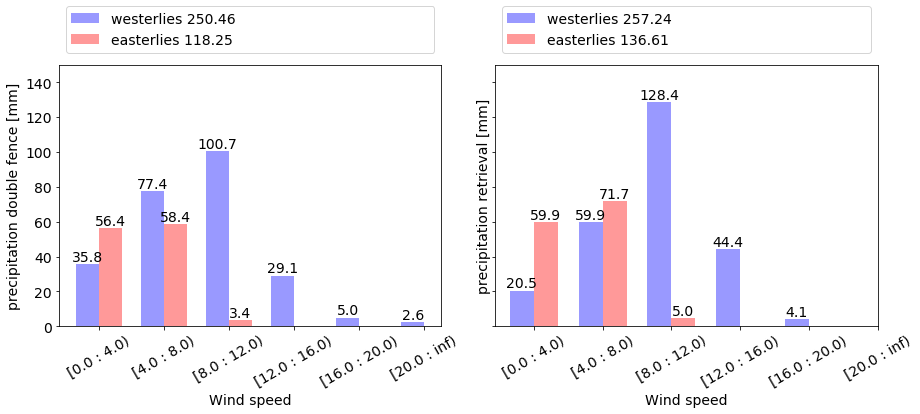

In [99]:
plt.rcParams.update({'font.size': 14})

bar_width = 0.35
opacity = 0.4

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(6)
f.set_figwidth(13)

bar11= ax1.bar(np.arange(obs_precip_west_ws.shape[0])-bar_width/2, 
              obs_precip_west_ws[:,1], width = bar_width,
       align='center', alpha=opacity, color='b', label='westerlies %s' %(np.round(np.nansum(obs_precip_west_ws[:,1]),2)))
bar12 = ax1.bar(np.arange(obs_precip_east_ws.shape[0])+bar_width/2, 
              obs_precip_east_ws[:,1], width = bar_width,
       align='center', alpha=opacity, color='r', label='easterlies %s' %(np.round(np.nansum(obs_precip_east_ws[:,1]),2)))
ax1.set_ylim([0, 150])
ax1.set_xlabel('Wind speed')
ax1.set_ylabel('precipitation double fence [mm]')
ax1.set_xticks(np.arange(obs_precip_west_ws.shape[0]))
ax1.set_xticklabels(['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'], rotation=30)
# Add counts above the two bar graphs
for rect in bar11 + bar12:
    height = rect.get_height()
    if np.isnan(height):
        continue
    else:
        ax1.text(rect.get_x() + rect.get_width()/2.0, height, '%s' % str(np.round(height,1)), ha='center', va='bottom')
#ax1.set_title('double fence')
ax1.legend(bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand')

bar21= ax2.bar(np.arange(ret_precip_west_ws.shape[0])-bar_width/2, 
              ret_precip_west_ws[:,1], width = bar_width,
       align='center', alpha=opacity, color='b', label='westerlies %s' %(np.round(np.nansum(ret_precip_west_ws[:,1]),2)))
bar22 = ax2.bar(np.arange(ret_precip_east_ws.shape[0])+bar_width/2, 
              ret_precip_east_ws[:,1], width = bar_width,
       align='center', alpha=opacity, color='r', label='easterlies %s' %(np.round(np.nansum(ret_precip_east_ws[:,1]),2)))

ax2.set_xlabel('Wind speed')
ax2.set_ylabel('precipitation retrieval [mm]')
ax2.set_xticks(np.arange(ret_precip_west_ws.shape[0]))
ax2.set_xticklabels(['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'], rotation=30)
# Add counts above the two bar graphs
for rect in bar21 + bar22:
    height = rect.get_height()
    if np.isnan(height):
        continue
    else:
        ax2.text(rect.get_x() + rect.get_width()/2.0, height, '%s' % str(np.round(height,1)), ha='center', va='bottom')
#ax2.set_title('retrieval')
ax2.legend(bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand')

plt.tight_layout()

if savefig == 1:
    cF.createFolder('%s/' %(figdir))
    fig_name = 'winter_16_17_obs_ret'
    plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches ='tight')
    print('plot saved: %s/%s' %(figdir, fig_name))
else:
    plt.show()

### MEPS data

In [ ]:
def fill_values(variable):
    if np.ma.is_masked(variable):
        mask = np.ma.getmaskarray(variable[:,:,:])
        marr = np.ma.array(variable[:,:,:], mask = mask, fill_value = np.nan)
        filled = marr.filled(np.nan)
        
    else:
        filled = variable[:]
        
    return(filled)

In [ ]:
meps_f = dict()
meps_precip_acc = dict()
meps_xwind_10m = dict()
meps_ywind_10m = dict()
meps_diff = dict()
meps_wind_dir   = dict()
meps_wind_speed = dict()
meps_westerly_idx = dict()
meps_easterly_idx = dict()
meps_westerly = dict()
meps_easterly = dict()
meps_total_precip = dict()
meps_precip_west  = dict()
meps_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        meps_dirnc = '../../Data/MEPS/%s/%s%s/sfc_hybrid5_allEM_00/%s%s%s_00.nc' %(station,year,month,year,month,day)
        try:
            meps_f[int(year+month+day)] = netCDF4.Dataset(meps_dirnc, 'r')
        except OSError:
            print('no file found: %s' %meps_dirnc)
#            meps_precip_acc[int(year+month+day)] = np.empty(shape=(67, 1, 10))
 #           meps_xwind_10m[int(year+month+day)] = np.empty(shape=(67, 1, 10))
  #          meps_ywind_10m[int(year+month+day)] = np.empty(shape=(67, 1, 10))
            
            meps_total_precip[int(year+month+day)] = np.empty(shape=(10, ))
            meps_total_precip[int(year+month+day)][:] = np.nan
            meps_precip_east[int(year+month+day)] = np.empty(shape=(10, ))
            meps_precip_east[int(year+month+day)][:] = np.nan
            meps_precip_west[int(year+month+day)] = np.empty(shape=(10, ))
            meps_precip_west[int(year+month+day)][:] = np.nan
            meps_wind_dir[int(year+month+day)] = np.empty(shape=(25, 1, 10))
            meps_wind_dir[int(year+month+day)][:] = np.nan
            meps_wind_speed[int(year+month+day)] = np.empty(shape=(25, 1, 10))
            meps_wind_speed[int(year+month+day)][:] = np.nan
            continue

        meps_precip_acc[int(year+month+day)] = (meps_f[int(year+month+day)].variables['precipitation_amount_acc'][:])
        meps_xwind_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['x_wind_10m'][:])
        meps_ywind_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['y_wind_10m'][:])
        
        ## substitute missing values with nan
        meps_precip_acc[int(year+month+day)] = fill_values(meps_precip_acc[int(year+month+day)][:,:,:])
        meps_xwind_10m[int(year+month+day)] = fill_values(meps_xwind_10m[int(year+month+day)][:,:,:])
        meps_ywind_10m[int(year+month+day)] = fill_values(meps_ywind_10m[int(year+month+day)][:,:,:])
        
#        meps_wind_dir_10m[int(year+month+day)]   = (meps_f[int(year+month+day)].variables['10m_wind_dir_mast1'][:])
#        meps_wind_speed_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['10m_wind_speed_mast1'][:])
        
        meps_f[int(year+month+day)].close
        

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        meps_diff[int(year+month+day)] = np.empty(shape=(meps_precip_acc[int(year+month+day)].shape))#/60))
        meps_diff[int(year+month+day)][:] =  np.nan

        for i in np.arange(0,meps_precip_acc[int(year+month+day)].shape[0]-1):
            meps_diff[int(year+month+day)][int(i),:,:] = meps_precip_acc[int(year+month+day)][int(i)+1,:,:] - \
                                                         meps_precip_acc[int(year+month+day)][int(i),:,:]

        #### calculate wind direction / speed
        meps_wind_dir[int(year+month+day)] = np.arctan2(meps_ywind_10m[int(year+month+day)][:,:,:], 
                                                        meps_xwind_10m[int(year+month+day)][:,:,:]) 
        meps_wind_dir[int(year+month+day)] = 270 - np.rad2deg(meps_wind_dir[int(year+month+day)])
        larger360 = np.where(meps_wind_dir[int(year+month+day)][:,:,:] > 360.)
        meps_wind_dir[int(year+month+day)][larger360] = meps_wind_dir[int(year+month+day)][larger360]-360
    
        meps_wind_speed[int(year+month+day)] = np.sqrt((meps_xwind_10m[int(year+month+day)][:,:,:])**2 + \
                                                           (meps_ywind_10m[int(year+month+day)][:,:,:])**2 )
        
        ### only get values up to 24h
        meps_diff[int(year+month+day)] = meps_diff[int(year+month+day)][:25,:,:]
        meps_wind_dir[int(year+month+day)] = meps_wind_dir[int(year+month+day)][:25,:,:]
        meps_wind_speed[int(year+month+day)] = meps_wind_speed[int(year+month+day)][:25,:,:]

        # Find wind regimes and associated precip amount
        IDX = np.arange(meps_wind_dir[int(year+month+day)].shape[0])

        meps_westerly_idx[int(year+month+day)] = []
        meps_easterly_idx[int(year+month+day)] = []

        for ens_memb in range(10):
            ## find all meps_westerly regimes (202.5 - 22.5 deg) 
            meps_westerly_idx[int(year+month+day)].append(IDX[np.logical_or(
                    np.logical_and((meps_wind_dir[int(year+month+day)][:,0,ens_memb] >= 202.5), 
                                   (meps_wind_dir[int(year+month+day)][:,0,ens_memb] <= 360)),
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] <22.5))])
#        print(np.array(meps_westerly_idx[int(year+month+day)][ens_memb]).shape)


            ## find all meps_easterly regimes (22.5 - 202.5 deg)
            meps_easterly_idx[int(year+month+day)].append(IDX[np.logical_and(
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] >= 22.5),
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] < 202.5))])
#        print(np.array(meps_easterly_idx[int(year+month+day)][ens_memb]).shape)

        
        meps_westerly[int(year+month+day)] = meps_westerly_idx[int(year+month+day)]
        meps_easterly[int(year+month+day)] = meps_easterly_idx[int(year+month+day)]
        
        meps_easterly_idx[int(year+month+day)] = np.array(meps_easterly_idx[int(year+month+day)])
        meps_westerly_idx[int(year+month+day)] = np.array(meps_westerly_idx[int(year+month+day)])

        meps_total_precip[int(year+month+day)] = []
        meps_precip_east[int(year+month+day)] = []
        meps_precip_west[int(year+month+day)] = []

        for ens_memb in range(10):
            if len(meps_westerly[int(year+month+day)][ens_memb]) == 0:    # only easterlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(len(meps_westerly[int(year+month+day)][ens_memb]),2))

            elif len(meps_easterly[int(year+month+day)][ens_memb]) == 0:  # only westerlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(len(meps_easterly[int(year+month+day)][ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2))

            else:    # both easterlies and westerlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2))
            

            # assign sum values to days
            total = np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                    np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_total_precip[int(year+month+day)].append(total)
    
            easterly = np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_precip_east[int(year+month+day)].append(easterly)
    
            westerly = np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_precip_west[int(year+month+day)].append(westerly)
            
        ## set days, still with not exisiting observation data to 0 mm precipitation
        if np.isnan(obs_total_precip[int(year+month+day)]):
            print([int(year+month+day)], 'total precip is NAN')
            obs_total_precip[int(year+month+day)] = 0.0
            meps_total_precip[int(year+month+day)] = np.zeros(shape=(10,))
        if np.isnan(obs_precip_east[int(year+month+day)]):
            print([int(year+month+day)], 'easterly is NAN')
            obs_precip_east[int(year+month+day)] = 0.0
            meps_precip_east[int(year+month+day)] = np.zeros(shape=(10,))
        if np.isnan(obs_precip_west[int(year+month+day)]):
            print([int(year+month+day)], 'westerly is NAN')
            obs_precip_west[int(year+month+day)] = 0.0
            meps_precip_west[int(year+month+day)] = np.zeros(shape=(10,))
        
        
        ## set days with less than 24h recorded values to 0mm precipitation
#        if len(obs_easterly[int(year+month+day)])+len(obs_westerly[int(year+month+day)]) != 1440 and \
 #           len(obs_easterly[int(year+month+day)])+len(obs_westerly[int(year+month+day)]) != 24:
  #          print([int(year+month+day)], 'less than 24h observation')
   #         obs_total_precip[int(year+month+day)] = 0.0
    #        meps_total_precip[int(year+month+day)] = np.zeros(shape=(10,))
     #       obs_precip_east[int(year+month+day)] = 0.0
      #      meps_precip_east[int(year+month+day)] = np.zeros(shape=(10,))
       #     obs_precip_west[int(year+month+day)] = 0.0
        #    meps_precip_west[int(year+month+day)] = np.zeros(shape=(10,))
            
        if np.count_nonzero(~np.isnan(obs_wind_dir_rolling[int(year+month+day)][:])) != 1440 and \
           np.count_nonzero(~np.isnan(obs_wind_dir_rolling[int(year+month+day)][:])) != 24:
            print([int(year+month+day)], 'less than 24h observation')
            obs_total_precip[int(year+month+day)] = 0.0
            meps_total_precip[int(year+month+day)] = np.zeros(shape=(10,))
            obs_precip_east[int(year+month+day)] = 0.0
            meps_precip_east[int(year+month+day)] = np.zeros(shape=(10,))
            obs_precip_west[int(year+month+day)] = 0.0
            meps_precip_west[int(year+month+day)] = np.zeros(shape=(10,))
            
            
        ### for plotting, add 360 deg for wind direction less than 22.5 --> nicer to show westerlies and easterlies seperate
        obs_wind_dir_rolling[int(year+month+day)][np.where(obs_wind_dir_rolling[int(year+month+day)][:] < 22.5)] = obs_wind_dir_rolling[int(year+month+day)][np.where(obs_wind_dir_rolling[int(year+month+day)][:] < 22.5)]+360

        for ens_memb in range(10):
            meps_wind_dir[int(year+month+day)][np.where(meps_wind_dir[int(year+month+day)][:,0,ens_memb] < 22.5),0,ens_memb] = meps_wind_dir[int(year+month+day)][np.where(meps_wind_dir[int(year+month+day)][:,0,ens_memb] < 22.5),0,ens_memb]+360


In [ ]:
### Define colorbar colors
champ = 255.
memb_col = np.array([99,99,99])/champ       # ensemble member color
obs_col = np.array([108, 26, 200])/champ


for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
            
        fig = plt.figure(figsize=(8,2.67))

        fig.text(.0, .5, '10m - Wind direction [$^{o}$]', ha='center', va='center', rotation='vertical', fontsize = 16)
##########################################################
        ax1 = fig.add_subplot(111)

        for ens_memb in np.arange(2,10):
            ax1.plot(np.arange(meps_wind_dir[int(year+month+day)][:,:,ens_memb].shape[0]*60)[::60],
                     meps_wind_dir[int(year+month+day)][:,:,ens_memb], color = memb_col, linestyle= '-', label='_nolegend_')
        ax1.plot(np.arange(meps_wind_dir[int(year+month+day)][:,:,1].shape[0]*60)[::60],
             meps_wind_dir[int(year+month+day)][:,:,1], color = memb_col, linestyle = '-', label = 'ensemble member')
        ax1.plot(np.arange(meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60)[::60],
                 meps_wind_dir[int(year+month+day)][:,:,0], 'k', linewidth = 2, 
                 label = 'deterministic')
        if obs_wind_dir_rolling[int(year+month+day)].shape[0] == 24:
            ax1.plot(np.arange(60,obs_wind_dir_rolling[int(year+month+day)].shape[0]*60+60)[::60],
                    obs_wind_dir_rolling[int(year+month+day)][:], marker= '.', linestyle='-', color = obs_col, label = 'observation')
        else:
            ax1.plot(np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0]),
                 obs_wind_dir_rolling[int(year+month+day)][:], '.', color = obs_col, label = 'observation')#, markersize = 2)
        
        for k in np.arange(45,360,90):
            ax1.hlines(k,0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60, linestyles='dashed', linewidth = 1)
        for k in np.arange(0,360,90):
            ax1.hlines(k,0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60, linewidth = 1)
#        ax1.hlines(135,0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60, linestyles='dashed', linewidth = 1)
 #       ax1.hlines(180,0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60, linewidth = 1)
  #      ax1.hlines(225,0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60, linestyles='dashed', linewidth = 1)
   #     ax1.hlines(270,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linewidth = 1)
    #    ax1.hlines(315,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linestyles='dashed', linewidth = 1)

        ax1.fill_between(np.arange(meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60), 202.5, 360+22.5,  facecolor='gray', alpha=0.4)
#        ax1.fill_between(np.arange(meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60), 0, 22.5,  facecolor='gray', alpha=0.4)

        ax1.set_xlim([0, meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60-60])
#        ax1.set_ylim([0, 360])
        ax1.set_ylim([22.5, 360+22.5])
        ax1.set_xticks(np.arange(0,meps_wind_dir[int(year+month+day)][:,:,0].shape[0]*60,120))    
        ax1.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24 ])
        ax1.set_yticks([22.5, 45, 90, 135, 180, 225,270,315,360])
#        ax1.set_yticklabels(['N', '', 'E', '', 'S', '', 'W', '', 'N' ])
        ax1.set_yticklabels(['22.5', '', 'E', '', 'S', '', 'W', '', 'N' ])
        fig.suptitle("%s-%s-%s" %(year,month,day), fontsize=14,fontweight='bold')
        ax1.tick_params(labelsize=14)

        lgd = ax1.legend(loc = 'center right', bbox_to_anchor = (1.54,0.26), 
                         fancybox=True, shadow=True, ncol=1, fontsize=16)

        fig_name = '%s%s%s_00.%s' %(year,month,day,form)
        if savefig == 1:
            cF.createFolder('%s/%s%s' %(figdir,year,month))
            plt.savefig('%s/%s%s/%s' %(figdir,year,month, fig_name), format = form, bbox_inches ='tight')
            print('plot saved: %s/%s%s/%s' %(figdir,year,month, fig_name))
        else:
            plt.show()
    
        plt.close()